# Modello di Kuramoto_0:
# $\frac{d \theta _{i} }{dt} = \omega _i + \frac{K}{N}\sum_{j=1}^N A_{ij} \sin (\theta _j - \theta _i ), \ \ i = 1, ..., N$

# Modello di Kuramoto_scale_free:
# $\frac{d \theta _{i} }{dt} = \omega _i + \frac{K}{k_{i}}\sum_{j=1}^N A_{ij} \sin (\theta _j - \theta _i ), \ \ i = 1, ..., N$ 

In [1]:
import igraph as ig
import matplotlib.pyplot as plt
import random
import numpy as np
import copy
%matplotlib widget
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({
  "text.usetex": True,
  "font.family": "Helvetica"
})


In [2]:
# function used

def motion(_q_0, _omegas, _K, _t_max, _dt, network):
    debug = False
    # how many vertices (oscillators)?
    _N = len(network.vs.indices)
    q = _q_0
    t = 0
    q_plot = np.zeros((int(_t_max/_dt), _N))
    dq_plot = np.zeros((int(_t_max/_dt), _N))
    dq0 = _omegas
    for t_count in range(int(_t_max/dt)):
        if debug:   print("\n", t)        
        dq = kuramoto(q, _omegas, _K, network, t)
        q_plot[t_count] = q
        dq_plot[t_count] = dq
        if debug: print(dq)
#        q = eulero_esplicito(q, dq, dt)
        q = runge_kutta4(q, dq, dt, t, omegas, _K, network )
        q = q  % (2*np.pi)
        t += _dt
    return q_plot, dq_plot

def eulero_esplicito(q, dq, dt):
    return q + dq*dt

def runge_kutta4(q, dq, h, t, omegas, _K, network):
    f = kuramoto
    k1_dot_q = f(q, omegas, _K, network, t )
    k2_dot_q = f(q + k1_dot_q*h/2, omegas,  _K, network, t + h/2)
    k3_dot_q = f(q + k2_dot_q*h/2, omegas, _K, network, t + h/2)
    k4_dot_q = f(q + k3_dot_q*h, omegas,  _K, network, t + h)
    q = (q + (k1_dot_q + 2*k2_dot_q + 2*k3_dot_q + k4_dot_q)*h/6.0)
    return q

def kuramoto_0(_q, _omegas, _K, network, t):
    _N = len(network.vs.indices)
    _dq = copy.deepcopy(_omegas)
    A_ij = network.get_adjacency()
#    print("prima", _dq)
    for i in range(_N):
        for j in range(_N):
            _dq[i] -= A_ij[i][j] * (_K/_N) * np.sin(_q[i] - _q[j])
#    print("dopo:",_dq)
    return _dq


def kuramoto(_q, _omegas, _K, network, t):
    _N = len(network.vs.indices)
    _dq = copy.deepcopy(_omegas)
    A_ij = network.get_adjacency()
#    print("prima", _dq)
    for i in range(_N):
        for j in range(_N):
            _dq[i] -= A_ij[i][j] * (_K/ ( np.sum(A_ij[i]) + 1) ) * np.sin(_q[i] - _q[j])
#    print("dopo:",_dq)
    return _dq

def kuramoto_1(_q, _omegas, _K, network, t):
    _N = len(network.vs.indices)
    _dq = copy.deepcopy(_omegas)
    A_ij = network.get_adjacency()
#    print("prima", _dq)
    for i in range(_N):
        for j in range(_N):
            _dq[i] -= A_ij[i][j] * _K * np.sin(_q[i] - _q[j])
#    print("dopo:",_dq)
    return _dq

In [3]:
#  initial values
# Set a random seed for reproducibility
N = 20
dt = 0.1
t_max = 10
random.seed(0)
q_0 = np.random.rand(N)*2*np.pi
omegas = np.random.rand(N)
# for plotting
t_span = np.linspace(0, t_max, int(t_max/dt))


Erdos-Renyi: IGRAPH U--- 20 190 --
+ edges:
 0 --  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19   17 --  0  1
2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19
 1 --  0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19   18 --  0  1
2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 19
 2 --  0  1  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19   19 --  0  1
2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18
 3 --  0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 4 --  0  1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 5 --  0  1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19
 6 --  0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 16 17 18 19
 7 --  0  1  2  3  4  5  6  8  9 10 11 12 13 14 15 16 17 18 19
 8 --  0  1  2  3  4  5  6  7  9 10 11 12 13 14 15 16 17 18 19
 9 --  0  1  2  3  4  5  6  7  8 10 11 12 13 14 15 16 17 18 19
10 --  0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19
11 --  0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 19
12 --  0

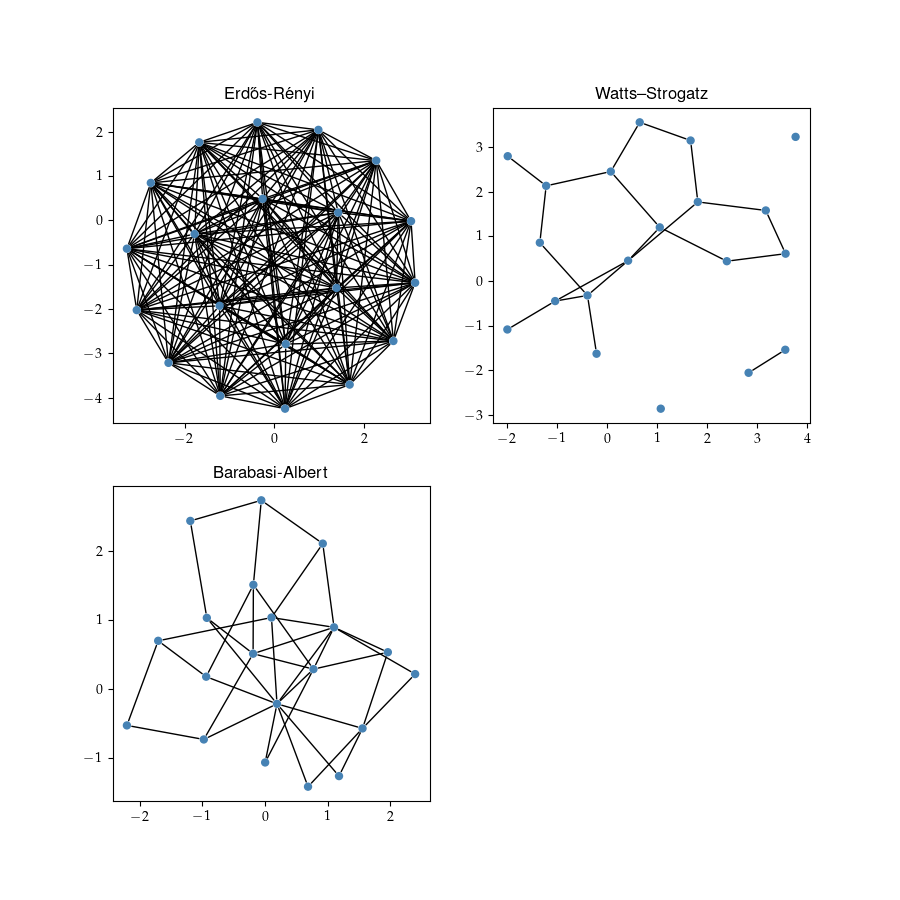

In [45]:
random.seed(0)
name_graph = {1: "Erdős-Rényi", 2: "Watts–Strogatz", 3: "Barabasi-Albert"}
# Generate Erdos Renyi graphs based on probability
g_erdos_renyi = ig.Graph.Erdos_Renyi(n=N, p=1, directed=False, loops=False)
g_watts_strogatz = ig.Graph.Watts_Strogatz(dim = 1, size = 20, nei = 1, p = 0.2)
g_barabasi_albert = ig.Graph.Barabasi(n = N, m = 2 )

# Print out summaries of each graph
print("Erdos-Renyi: {} \n Watts-Strogatz: {} \n Barabasi-Albert: {}".format(
    str(g_erdos_renyi), str(g_barabasi_albert), str(g_watts_strogatz)))


#new figure to plot network graphs
fig_graph = plt.figure(figsize = (9, 9) )
axs_graph = [fig_graph.add_subplot(2,2,1), fig_graph.add_subplot(2,2,2), fig_graph.add_subplot(2,2,3)]
ig.plot(g_erdos_renyi, target=axs_graph[0], color='pink')
ig.plot(g_watts_strogatz, target=axs_graph[1])
ig.plot(g_barabasi_albert, target=axs_graph[2])
for i in range(len(axs_graph)):  
    axs_graph[i].set(title=name_graph[i+1])


In [ ]:
K = 1.4
fig_plot = plt.figure(figsize = (9, 9) )
axs_plot = [fig_plot.add_subplot(2,2,1), fig_plot.add_subplot(2,2,2), fig_plot.add_subplot(2,2,3)]

q_plot_erd_ren, dq_plot_erd_ren = motion(q_0, omegas, K, t_max, dt, g_erdos_renyi)
axs_plot[0].clear()
axs_plot[0].plot(t_span[::], dq_plot_erd_ren[::, 0:20])

q_plot_watt_strog, dq_plot_watt_strog = motion(q_0, omegas, K, t_max, dt, g_watts_strogatz)
axs_plot[1].clear()
axs_plot[1].plot(t_span[::], dq_plot_watt_strog[::, 0:20])

q_plot_barabasi_albert, dq_plot_barabasi_albert = motion(q_0, omegas, K, t_max, dt, g_barabasi_albert)
axs_plot[2].clear()
axs_plot[2].plot(t_span[::], dq_plot_barabasi_albert[::, 0:20])

for i in range(len(axs_plot)):  
    axs_plot[i].set(xlabel="$t (s)$", ylabel=r"$\theta '$", title=name_graph[i+1])

fig_plot_q_t.suptitle("dQ vs t plot", fontsize = 16)

In [ ]:
fig_plot_q_t = plt.figure(figsize = (9, 9) )
axs_plot_q_t = [fig_plot_q_t.add_subplot(2,2,1), fig_plot_q_t.add_subplot(2,2,2), fig_plot_q_t.add_subplot(2,2,3)]

axs_plot_q_t[0].clear()
axs_plot_q_t[0].plot(t_span[::], q_plot_erd_ren[::, 0:20])

axs_plot_q_t[1].clear()
axs_plot_q_t[1].plot(t_span[::], q_plot_watt_strog[::, 0:20])

axs_plot_q_t[2].clear()
axs_plot_q_t[2].plot(t_span[::], q_plot_barabasi_albert[::, 0:20])

for i in range(len(axs_plot_q_t)):  
    axs_plot_q_t[i].set(xlabel="$t (s)$", ylabel=r"$\theta$", title=name_graph[i+1])

fig_plot_q_t.suptitle("Q vs t plot", fontsize = 16)


### studiare il parametro d'ordine r di Kuramoto, in funzione del parametro di controllo K, e fare un plot r(K) vs K dove dovrebbe trovare una curva simile a quella di una transizione di fase (cosa che infatti è, si passa da moto disordinato a moto collettivo).

### fare la stessa simulazione (a parità di rete o di modello di rete) più e più volte, e poi mediare.

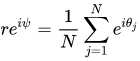

$r, \psi$ parametri d'ordine

nel caso di un network si può definire:

$ r =  \|  \sum_{j = 1}^N \frac{1}{k_j} e^{i \theta _i } \| \ , \ \ i = 1, ..., N$ 

In [32]:
def kuramoto_r(_q, _omegas, network):
    _N = len(network.vs.indices)
    network_connected = np.array(network.get_adjacency().data).sum(axis=1).flatten()
    r = np.abs( np.sum( np.exp(np.cdouble(_q)*1j) / (network_connected + 1)) )
    return r

def kuramoto_r_mean(_q_0, _omegas, _K,_t_max, _dt, network):
    r = 0
    q_plot, dq_plot = motion(_q_0, _omegas, _K, _t_max, _dt, network)
    network_connected = np.array(network.get_adjacency().data).sum(axis=1).flatten()
    r_max_network = np.sum(1/(1 + network_connected))
    for t_count in range(int(_t_max/dt)):
        r += kuramoto_r(q_plot[t_count], _omegas, network)
    
    #media
    r *= 1./int(t_max/dt)
    print(r_max_network)
    #normalizzo rispetto a r_max possibile per il network
    r /= r_max_network
    return r

In [ ]:
q_0 = np.random.rand(N)*2*np.pi
omegas = np.random.rand(N)

K_start = 0
K_end = 100
K_step = 4
K_cycle = np.arange(K_start, K_end, K_step)

r_mean_erdos_renyi = []
for K in K_cycle:
    r = kuramoto_r_mean(q_0, omegas, K, t_max, dt, g_erdos_renyi)
    r_mean_erdos_renyi.append(r)
    print("K: {} - r_mean/K: {}".format(K, r))


1.0000000000000002
K: 0 - r_mean/K: 0.37712621115806766
1.0000000000000002
K: 4 - r_mean/K: 0.9445994875333009
1.0000000000000002
K: 8 - r_mean/K: 0.9684800194087226
1.0000000000000002
K: 12 - r_mean/K: 0.976946691239715
1.0000000000000002
K: 16 - r_mean/K: 0.9812653741634757
1.0000000000000002
K: 20 - r_mean/K: 0.9838423993080838
1.0000000000000002
K: 24 - r_mean/K: 0.9854911423083399
1.0000000000000002
K: 28 - r_mean/K: 0.9857001938605856
1.0000000000000002
K: 32 - r_mean/K: 0.9785074913462077
1.0000000000000002
K: 36 - r_mean/K: 0.9811375335059902
1.0000000000000002
K: 40 - r_mean/K: 0.9722584231950961


In [44]:
r_mean_watts_strogatz = []
for K in K_cycle:
    r = kuramoto_r_mean(q_0, omegas, K, t_max, dt, g_watts_strogatz)
    r_mean_watts_strogatz.append(r)
    print("K: {} - r_mean/K: {}".format(K, r))

6.916666666666666
K: 0 - r_mean/K: 0.23811903308463514
6.916666666666666
K: 4 - r_mean/K: 0.7198454218512673
6.916666666666666
K: 8 - r_mean/K: 0.8100032867013036
6.916666666666666
K: 12 - r_mean/K: 0.8576945470853853
6.916666666666666
K: 16 - r_mean/K: 0.887587906787497
6.916666666666666
K: 20 - r_mean/K: 0.9077458434527407
6.916666666666666
K: 24 - r_mean/K: 0.9105605542671287
6.916666666666666
K: 28 - r_mean/K: 0.9164760249357204
6.916666666666666
K: 32 - r_mean/K: 0.9139217270418437
6.916666666666666
K: 36 - r_mean/K: 0.6928937130298188
6.916666666666666
K: 40 - r_mean/K: 0.3573869520359596
6.916666666666666
K: 44 - r_mean/K: 0.29353504253628276
6.916666666666666
K: 48 - r_mean/K: 0.3266538578497477
6.916666666666666
K: 52 - r_mean/K: 0.27762718186333174
6.916666666666666
K: 56 - r_mean/K: 0.2558311155555862
6.916666666666666
K: 60 - r_mean/K: 0.2533824387013722
6.916666666666666
K: 64 - r_mean/K: 0.25039074456378324
6.916666666666666
K: 68 - r_mean/K: 0.25262034917577614
6.9166666

In [11]:
q_0 = np.random.rand(N)*2*np.pi
omegas = np.random.rand(N)
r_mean_barabasi_albert = []
for K in K_cycle:
    r = kuramoto_r_mean(q_0, omegas, K, t_max, dt, g_barabasi_albert)
    r_mean_barabasi_albert.append(r)
    print("K: {} - r_mean/K: {}".format(K, r))

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.04775804-0.32989435j -0.10187216+0.04435923j  0.14247175+0.01048631j
  0.08575457-0.03017643j -0.16092324-0.11875905j -0.01685027+0.24943149j
  0.05387744-0.1577181j   0.22192323+0.11510899j -0.02043469+0.16540919j
 -0.18572287+0.27679979j  0.13861862+0.09253461j -0.13256566+0.14975428j
 -0.23962173-0.07128413j  0.20065713+0.26617255j  0.2785401 +0.1831025j
  0.22613413+0.24489685j -0.3315661 +0.03427873j -0.05459724-0.3288

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.0544548 -0.32885527j -0.10465455+0.0373243j   0.14276145+0.00522791j
  0.08667091-0.02743384j -0.1468176 -0.13581087j  0.00711123+0.24989884j
  0.07608231-0.14828776j  0.21235213+0.13193397j -0.02825386+0.16425437j
 -0.1461139 +0.2996028j   0.14231347+0.08674476j -0.11349824+0.16467589j
 -0.24771716-0.03370771j  0.22396007+0.24688661j  0.27988223+0.18104433j
  0.2578774 +0.21121165j -0.33124123+0.03728749j -0.04266069-0.330

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.05989216-3.27908585e-01j -0.10648416+3.17301684e-02j
  0.14285714+4.41321880e-05j  0.08747301-2.47575314e-02j
 -0.1252622 -1.55914656e-01j  0.02759683+2.48472162e-01j
  0.0984644 -1.34471334e-01j  0.20464372+1.43599965e-01j
 -0.03141436+1.63679308e-01j -0.10561443+3.16159301e-01j
  0.14581801+8.07148421e-02j -0.0909727 +1.78112234e-01j
 -0.24999548-1.50384813e-03j  0.25485366+2.14850465e-01j
  0.280387  +1.80261594e-01j  0.

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 6.42671303e-02-0.32707927j -1.07626538e-01+0.0276081j
  1.42769575e-01-0.00500118j  8.81770617e-02-0.02211942j
 -9.28488863e-02-0.17714142j  4.51906311e-02+0.24588169j
  1.19267817e-01-0.1164172j   2.00032567e-01+0.14995657j
 -2.96775956e-02+0.1640031j  -6.51470187e-02+0.32690515j
  1.48874365e-01+0.07492797j -6.51073506e-02+0.18910588j
 -2.48759873e-01+0.02487018j  2.88299369e-01+0.16731582j
  2.80553261e-01+0.18000272j  2.9

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.06773245-0.32637927j -0.10827776+0.02493202j  0.14252953-0.00966934j
  0.08881072-0.01941953j -0.04833472-0.19407152j  0.06052981+0.24256163j
  0.13653095-0.09558806j  0.19929673+0.15093315j -0.0231477 +0.16505139j
 -0.02547625+0.33235835j  0.1514358 +0.06960587j -0.03640795+0.19665823j
 -0.24581122+0.04557238j  0.31532472+0.10808068j  0.28048913+0.18010264j
  0.30691887+0.13004583j -0.33076847+0.04127144j  0.03423406-0.331

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.07038775-0.32581694j -0.10857223+0.02361675j  0.14222956-0.0133759j
  0.08939971-0.01649713j  0.0026439 -0.19998252j  0.07417933+0.23874134j
  0.14912802-0.07442185j  0.20232051+0.14685507j -0.0121071 +0.16622634j
  0.01233428+0.33310505j  0.15367527+0.06451115j -0.00604474+0.19990863j
 -0.24254946+0.06057855j  0.32923781+0.05209198j  0.2798882 +0.1810351j
  0.31320573+0.11407576j -0.33061163+0.04250957j  0.07818477-0.32403

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.07227127-0.32540433j -0.10860455+0.02346766j  0.14204484-0.01521269j
  0.08994551-0.01320105j  0.04761742-0.19424876j  0.08656182+0.23453582j
  0.15737413-0.05487405j  0.20777366+0.13903275j  0.00315362+0.16663683j
  0.04650245+0.33007368j  0.15594015+0.05882557j  0.02374772+0.19858511j
 -0.24018257+0.06937097j  0.33283322+0.01825261j  0.27801019+0.18390607j
  0.31598025+0.10614891j -0.33037803+0.04428849j  0.12988884-0.306

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.07335336-0.32516211j -0.10846696+0.02409559j  0.14212672-0.01442766j
  0.09040451-0.00956495j  0.07764655-0.18431227j  0.09790808+0.23003045j
  0.1624559 -0.03722711j  0.21368787+0.12975938j  0.02244468+0.16514846j
  0.07434515+0.32493678j  0.15859159+0.05124925j  0.04941634+0.19379893j
 -0.23964861+0.07119371j  0.33315636+0.01086046j  0.27370914+0.19024831j
  0.31541177+0.10782638j -0.33003461+0.04677892j  0.18316587-0.278

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.07353845-0.3251203j  -0.10830112+0.02483033j  0.14241594-0.01121892j
  0.09071089-0.00599981j  0.09554198-0.17570353j  0.10820821+0.22536855j
  0.16538621-0.0206199j   0.21898269+0.12060921j  0.04537404+0.16037136j
  0.09270762+0.32018184j  0.16166114+0.04053954j  0.06662773+0.18857557j
 -0.24115423+0.06591388j  0.33308611+0.0128356j   0.26572564+0.20124859j
  0.3113995 +0.11891789j -0.32956532+0.04997809j  0.2286071 -0.242

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.07268157-0.32531293j -0.10832211+0.02473862j  0.14268508-0.00700939j
  0.09085252-0.00320664j  0.11054696-0.16667144j  0.11717927+0.22083708j
  0.16660481-0.0045404j   0.2243437 +0.11031728j  0.07040026+0.15106813j
  0.09952701+0.3181281j   0.16450589+0.02675048j  0.07221185+0.18650858j
 -0.24387909+0.05498173j  0.33329041+0.00534921j  0.25392061+0.21595239j
  0.30502552+0.13442671j -0.32898528+0.05366373j  0.25841242-0.210

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.07061496-0.32576777j -0.10872557+0.02290043j  0.14281233-0.00357787j
  0.09089467-0.00161916j  0.12801835-0.1536597j   0.12436691+0.21687063j
  0.16633081+0.01057547j  0.23083871+0.09598692j  0.09414819+0.1375278j
  0.09671935+0.31899291j  0.1661595 +0.0129922j   0.06791162+0.18811702j
 -0.24664652+0.04081046j  0.33318625-0.00990109j  0.24261269+0.22858302j
  0.3016688 +0.14179933j -0.32836092+0.05736044j  0.27116614-0.1938

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.06715816-0.32649792j -0.10949158+0.01890167j  0.14284387-0.00194763j
  0.09090525-0.0008359j   0.14674868-0.13588534j  0.12970328+0.21372192j
  0.16491881+0.02407415j  0.23741528+0.07831976j  0.11271527+0.12277234j
  0.09256988+0.32022169j  0.16655475+0.00610686j  0.06539056+0.18900814j
 -0.24887079+0.0237346j   0.33292755-0.0164425j   0.24501106+0.22601037j
  0.31025811+0.12186475j -0.32782626+0.06034117j  0.27229052-0.192

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.06207012-3.27503299e-01j -0.11033126+1.31412094e-02j
  0.14283417-2.56204303e-03j  0.09090909-3.15525608e-05j
  0.16513843-1.12824198e-01j  0.13488838+2.10487826e-01j
  0.16269595+3.61635922e-02j  0.24099705+6.64862543e-02j
  0.12427254+1.11059058e-01j  0.09809582+3.18572316e-01j
  0.16608932+1.38605934e-02j  0.08499547+1.81040797e-01j
 -0.2499998 +3.16659884e-04j  0.33324609-7.62580145e-03j
  0.27747803+1.84708029e-01j  0.

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.05492897-0.3287764j  -0.11091607+0.00658063j  0.14269612-0.006781j
  0.09090732+0.0005671j   0.18402243-0.078331j    0.14479309+0.20380128j
  0.15951185+0.04830888j  0.23725808+0.07879469j  0.12992352+0.10439184j
  0.11458349+0.31302034j  0.16211678+0.03867723j  0.13517095+0.14740697j
 -0.2478338 -0.03283913j  0.33320543-0.00923325j  0.32462322+0.07570257j
  0.32962139-0.04960697j -0.32780571+0.06045268j  0.28496134-0.17293

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.04501147-3.30280304e-01j -0.11111105+1.16300974e-04j
  0.14172101-1.79810689e-02j  0.09090841-3.50619815e-04j
  0.19724231-3.30979069e-02j  0.16511562+1.87714767e-01j
  0.15461736+6.22193667e-02j  0.20840527+1.38084184e-01j
  0.13290161+1.00573064e-01j  0.12413225+3.09357875e-01j
  0.15001265+7.26221980e-02j  0.1854899 +7.47896743e-02j
 -0.23879899-7.39935211e-02j  0.32454035-7.60570247e-02j
  0.32410125-7.79069311e-02j  0.

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.03133719-0.33185703j -0.11096221-0.0057503j   0.13748916-0.03879297j
  0.09089593-0.00154691j  0.1988282 -0.02161821j  0.194084  +0.15757982j
  0.14744466+0.07770361j  0.11405392+0.22246731j  0.13762042+0.09401275j
  0.09691691+0.31893295j  0.13154783+0.10233741j  0.19991576-0.00580405j
 -0.22089598-0.1170682j   0.27357092-0.19044701j  0.28150046-0.17851779j
  0.25533675-0.21427612j -0.32984888+0.04807106j  0.32366233-0.079

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.01302774-0.33307865j -0.11060345-0.01060918j  0.12844854-0.06252308j
  0.09088859+0.00193044j  0.18083913-0.08542371j  0.22000103+0.11874151j
  0.13911887+0.09178082j  0.03429368+0.24763672j  0.1468075 +0.0789008j
  0.01209092+0.33311398j  0.11506355+0.12057428j  0.19318714-0.05175644j
 -0.19492749-0.15653522j  0.26057816-0.20787047j  0.27322738-0.19093955j
  0.2438836 -0.22722654j -0.331208  +0.0375815j   0.33035853-0.0444

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[-0.01002954-0.33318241j -0.11020081-0.01419367j  0.12315595-0.0723932j
  0.09031137+0.01040767j  0.11760787-0.16176646j  0.23439812+0.08693402j
  0.13284471+0.10064821j  0.10592858+0.22644897j  0.15785251+0.05348237j
 -0.08999632+0.32095447j  0.10798491+0.1269529j   0.1915531 -0.05751008j
 -0.16175452-0.19061867j  0.32267706-0.08360995j  0.29536005-0.15451069j
  0.27322029-0.1909497j  -0.33237424+0.02526809j  0.33043485-0.0438

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[-0.03641248-0.33133856j -0.10972138-0.01751847j  0.12995797-0.05932191j
  0.08947255+0.01609739j  0.0425723 -0.19541648j  0.23829578+0.07559841j
  0.13194252+0.10182804j  0.1744482 +0.17907492j  0.16460326+0.02614471j
 -0.09017729+0.32090367j  0.11695282+0.11874264j  0.1970743 -0.03408402j
 -0.12330964-0.21747352j  0.33150305-0.03488326j  0.3133755 -0.11360856j
  0.32768413-0.06110826j -0.33318653+0.00989194j  0.32818358-0.058

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[-0.06250825-0.32741996j -0.10868662-0.02308458j  0.13850189-0.03500556j
  0.09063436+0.00706226j -0.01042999-0.19972785j  0.23108376+0.09539548j
  0.137515  +0.09416689j  0.15887798+0.19302276j  0.16594997+0.01543971j
  0.00930439+0.33320345j  0.14374184+0.08435674j  0.19943069+0.01507978j
 -0.09811847-0.22994079j  0.2928439 -0.15922801j  0.32341863-0.08069387j
  0.26229049+0.20570564j -0.33299912-0.01492314j  0.33305777-0.013

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[-0.08197977-0.32309508j -0.10634368-0.03219782j  0.14145725-0.01995016j
  0.08608448-0.029222j   -0.02876895-0.19792005j  0.19307517+0.15881429j
  0.14797851+0.07668206j  0.14670735+0.20242765j  0.16624625+0.01183054j
 -0.12672718+0.30830396j  0.16480676+0.02482963j  0.16770743+0.10896888j
 -0.10407311-0.22730769j  0.2140044 -0.25556453j  0.32752313-0.06196537j
 -0.04159901+0.33072743j -0.327566  -0.06173835j  0.30759859+0.128

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[-0.08526401-0.32224394j -0.10224519-0.04349253j  0.14166477-0.01841893j
  0.06855671-0.05970293j -0.0229191 -0.19868245j  0.08760389+0.23414858j
  0.15974461+0.04753354j  0.17942435+0.17408878j  0.16128621-0.04200638j
 -0.33331875-0.0031184j   0.16654629-0.00633346j  0.06872458+0.18782154j
 -0.10846052-0.22524723j  0.18365361-0.27817703j  0.32734017-0.06292476j
 -0.14710797+0.29911596j -0.30206888-0.14094503j  0.24391516+0.227

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[-0.05987542-0.32791164j -0.09674747-0.05464069j  0.13941941-0.03115111j
  0.06914891-0.05901602j  0.0063427 -0.1998994j  -0.00512066+0.24994755j
  0.16654377+0.00639938j  0.23692036+0.0798044j   0.11404447-0.12153862j
 -0.27899987-0.18240116j  0.16537294+0.02072604j  0.04651145+0.19451654j
 -0.0765448 -0.23799347j  0.18851294-0.27490723j  0.32474943+0.07515927j
  0.01970906+0.33275015j -0.23339979-0.23798246j  0.25307795+0.216

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.00437137-0.33330467j -0.09253839-0.06150062j  0.12542733-0.06838236j
  0.06785138-0.06050333j  0.06884923-0.18777588j  0.03493619+0.24754689j
  0.16214446-0.03856102j  0.21912119-0.1203574j   0.09203962-0.13894778j
 -0.26180273-0.20632605j  0.1547826 +0.06180717j  0.05312456+0.19281541j
 -0.05123002-0.24469468j  0.20138843-0.26561968j  0.0417164 +0.33071264j
  0.04826866+0.32982002j -0.12779144-0.30786435j  0.28596073+0.171

[ 4.23887865e-02-0.33062713j -9.71075765e-02+0.05399813j
  1.42804072e-01+0.00389362j  8.36736787e-02-0.03554122j
 -1.69273191e-01-0.10652036j -1.41589911e-04+0.24999996j
  4.68672101e-02-0.15994137j  2.29264307e-01+0.0996889j
 -1.05015740e-02+0.16633549j -1.80581594e-01+0.28018101j
  1.40631826e-01+0.08944533j -1.18385770e-01+0.16119804j
 -2.43623416e-01-0.05610375j  2.13953168e-01+0.25560742j
  2.88728207e-01+0.16657471j  2.41834841e-01+0.2294058j
 -3.27923429e-01+0.05981083j -7.25132542e-02-0.32535049j
 -3.26135679e-01-0.06889579j  3.28523150e-01-0.05642385j]
[ 0.09905423-0.31827562j -0.09443954-0.05853932j  0.08406635-0.1155033j
  0.05430891-0.07290408j  0.1130559 -0.16497989j -0.00500366+0.24994992j
  0.15004309-0.07255929j  0.12540577-0.21627157j  0.13478679-0.09803213j
 -0.19608981-0.269555j    0.13690185+0.0950561j  -0.00870529+0.19981045j
 -0.10321422-0.22769898j  0.22614145-0.24489009j  0.01849729+0.33281971j
 -0.17308151+0.28487524j -0.04341605-0.33049381j  0.31161025+0.1183

[Text(0.5, 0, '$K$'), Text(0, 0.5, '$r (K)$'), Text(0.5, 1.0, 'Erdős-Rényi')]

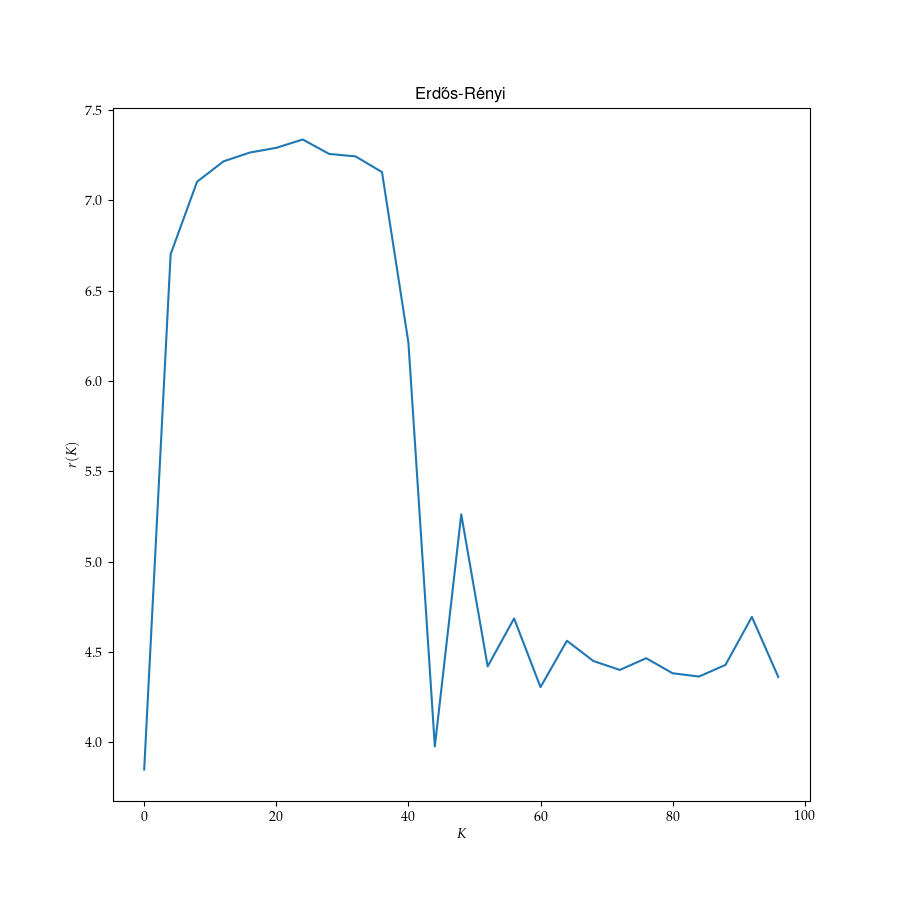

In [9]:
plt.close
fig_plot_r = plt.figure(figsize = (9, 9) )
axs_plot_r = [fig_plot_r.add_subplot(1,1,1)]
axs_plot_r[0].clear()
axs_plot_r[0].plot(K_cycle[::], r_mean_erdos_renyi)
axs_plot_r[0].set(xlabel="$K$", ylabel=r"$r (K)$", title=name_graph[1])

[Text(0.5, 0, '$K$'),
 Text(0, 0.5, '$r (K)$'),
 Text(0.5, 1.0, 'Watts–Strogatz')]

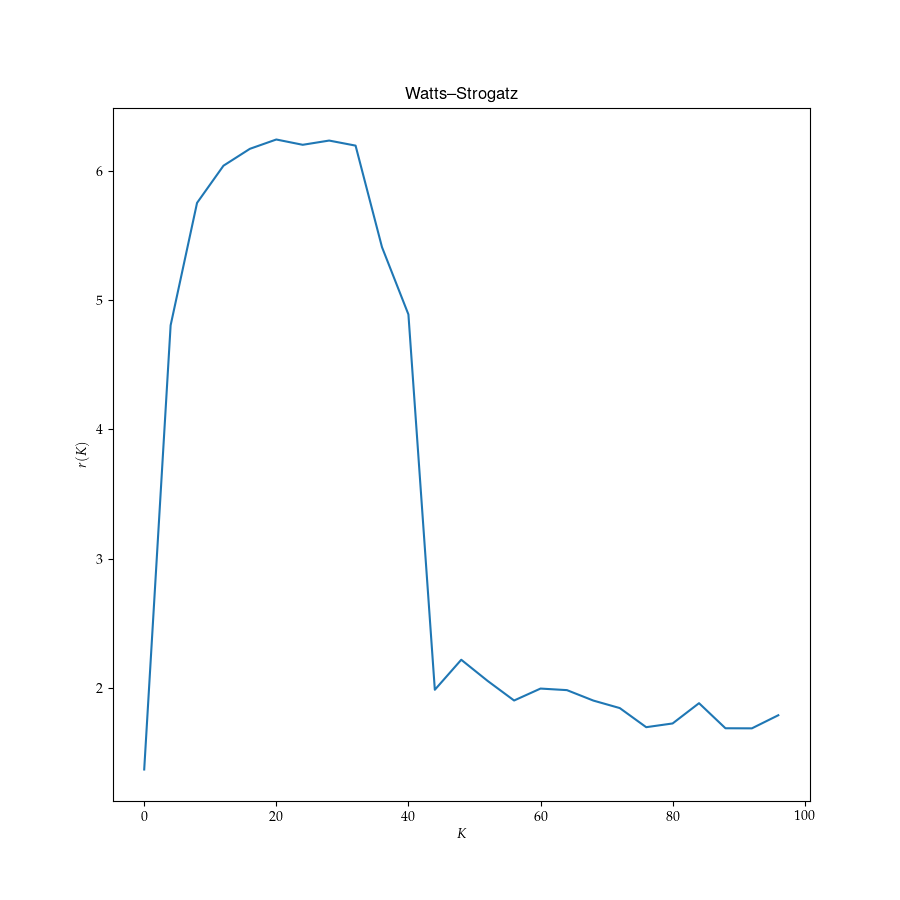

In [15]:
plt.close
fig_plot_r_watts_strogatz = plt.figure(figsize = (9, 9) )
axs_plot_r_watts_strogatz = [fig_plot_r_watts_strogatz.add_subplot(1,1,1)]
axs_plot_r_watts_strogatz[0].clear()
axs_plot_r_watts_strogatz[0].plot(K_cycle[::], r_mean_watts_strogatz)
axs_plot_r_watts_strogatz[0].set(xlabel="$K$", ylabel=r"$r (K)$", title=name_graph[2])

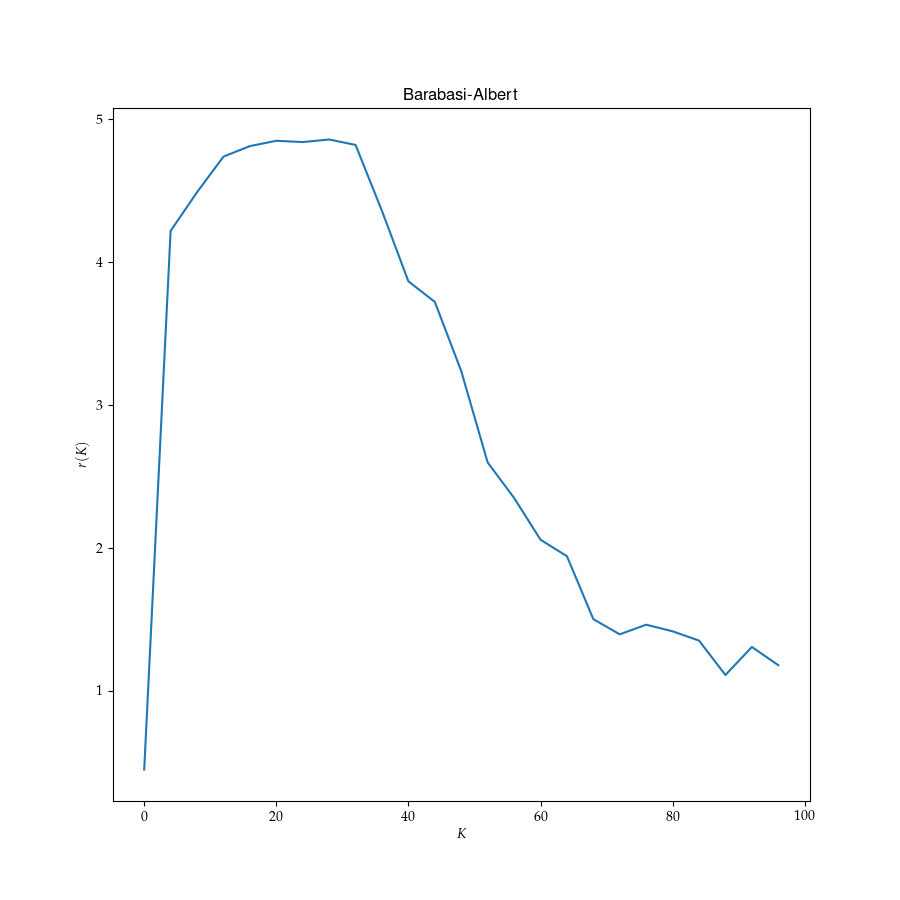

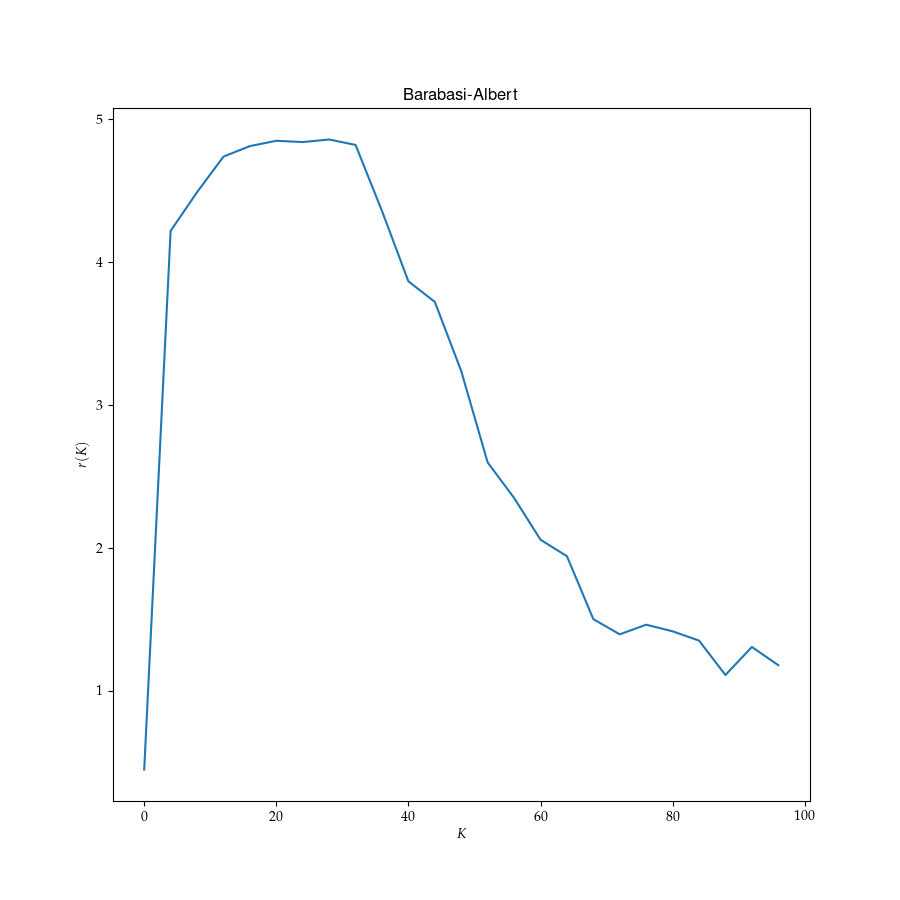

In [16]:
fig_plot_r_barabasi_albert = plt.figure(figsize = (9, 9) )
axs_plot_r_barabasi_albert = [fig_plot_r_barabasi_albert.add_subplot(1,1,1)]
axs_plot_r_barabasi_albert[0].clear()
axs_plot_r_barabasi_albert[0].plot(K_cycle[::], r_mean_barabasi_albert)
axs_plot_r_barabasi_albert[0].set(xlabel="$K$", ylabel=r"$r (K)$", title=name_graph[3])
fig_plot_r_barabasi_albert.show()

11.5
7.533333333333332
4.994877344877344
